In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from meteostat import Point, Daily
import random

In [ ]:
SEEDS FOR REPRODUCIBILITY TO ELIMINATE RANDOMNESS IN RESULTS

In [3]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Obtaining 10 years of temperature data from Meteostat
london = Point(51.5072, -0.1276) #lattitude and longitude of london
start = datetime(2015, 1, 1)
end = datetime(2024, 1, 1)

data = Daily(london, start, end).fetch()
temperature = data['tavg'].dropna().values.reshape(-1, 1)


In [ ]:
NORMALIZE THE DATA FOR FURTHER PROCESSING
DataLoader is used in creating the dataset to enhance the speed of computation and for batch training.

In [4]:
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(temperature)
temperature_scaled = torch.tensor(temperature_scaled, dtype=torch.float32)

# Dataset class
class TempDataset(Dataset):
    def __init__(self, series, seqlen):
        self.X = []
        self.Y = []
        for i in range(len(series) - seqlen):
            self.X.append(series[i:i+seqlen])
            self.Y.append(series[i+seqlen])
        self.X = torch.stack(self.X)
        self.Y = torch.stack(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

seqlength = 14
dataset = TempDataset(temperature_scaled, seqlength)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
CREATE THE LSTM Model

In [5]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, 1)
    #redefining the model's forward pass
    def forward(self, x):
        y = self.lstm(x)[0]
        o = self.out(y[:, -1, :])
        return o


In [ ]:
DEFINING PARAMETERS AND TRAIN THE MODEL ON THE DATE RANGE THAT WAS SPECIFIED EARLIER

In [6]:

input_size = 1
hidden_size = 32
num_layers = 2
num_epochs = 75
learning_rate = 0.05


net = LSTMnet(input_size, hidden_size, num_layers)
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

# Training loop
losses = []
net.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y_true in loader:
        y_pred = net(x)
        loss = lossfun(y_pred.squeeze(), y_true.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


Epoch 1/75, Loss: 0.025793
Epoch 2/75, Loss: 0.005588
Epoch 3/75, Loss: 0.005894
Epoch 4/75, Loss: 0.004179
Epoch 5/75, Loss: 0.004039
Epoch 6/75, Loss: 0.003697
Epoch 7/75, Loss: 0.003531
Epoch 8/75, Loss: 0.003721
Epoch 9/75, Loss: 0.003766
Epoch 10/75, Loss: 0.004022
Epoch 11/75, Loss: 0.003555
Epoch 12/75, Loss: 0.003704
Epoch 13/75, Loss: 0.003639
Epoch 14/75, Loss: 0.003702
Epoch 15/75, Loss: 0.003591
Epoch 16/75, Loss: 0.003600
Epoch 17/75, Loss: 0.003488
Epoch 18/75, Loss: 0.003845
Epoch 19/75, Loss: 0.003562
Epoch 20/75, Loss: 0.003467
Epoch 21/75, Loss: 0.003639
Epoch 22/75, Loss: 0.003408
Epoch 23/75, Loss: 0.003562
Epoch 24/75, Loss: 0.003564
Epoch 25/75, Loss: 0.003508
Epoch 26/75, Loss: 0.003379
Epoch 27/75, Loss: 0.003463
Epoch 28/75, Loss: 0.003566
Epoch 29/75, Loss: 0.003534
Epoch 30/75, Loss: 0.003402
Epoch 31/75, Loss: 0.003482
Epoch 32/75, Loss: 0.003373
Epoch 33/75, Loss: 0.003500
Epoch 34/75, Loss: 0.003524
Epoch 35/75, Loss: 0.003430
Epoch 36/75, Loss: 0.003492
E

In [ ]:
RUN INFERENCE ON THE TRAINING DATA
VISUALIZE THE ACTUAL VS PREDICTED TEMPERATURES AND ALSO THE TRAINING LOSS 

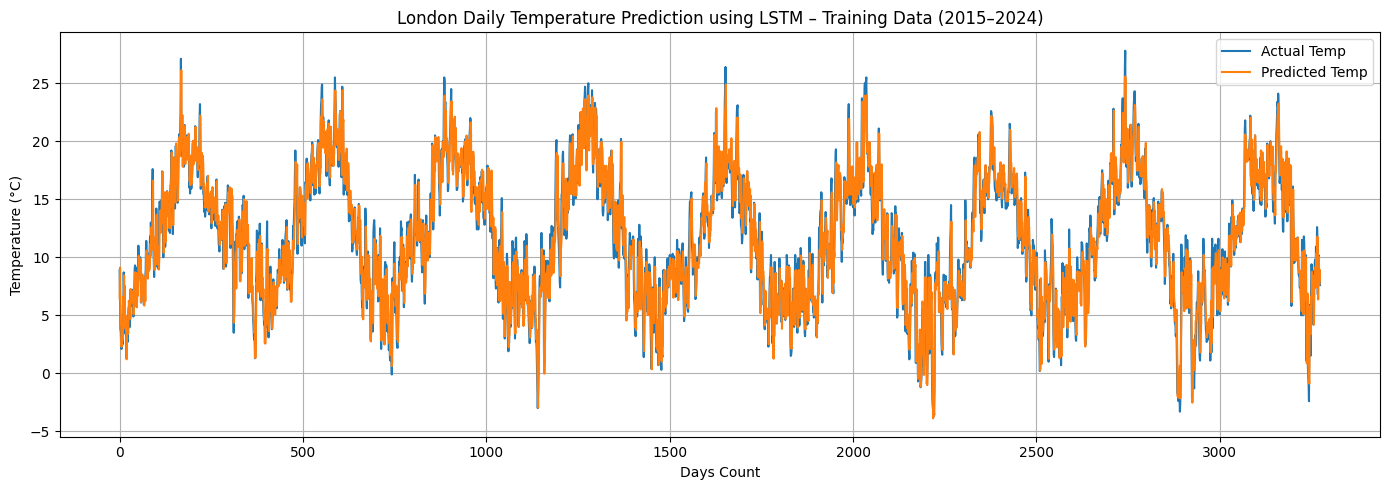

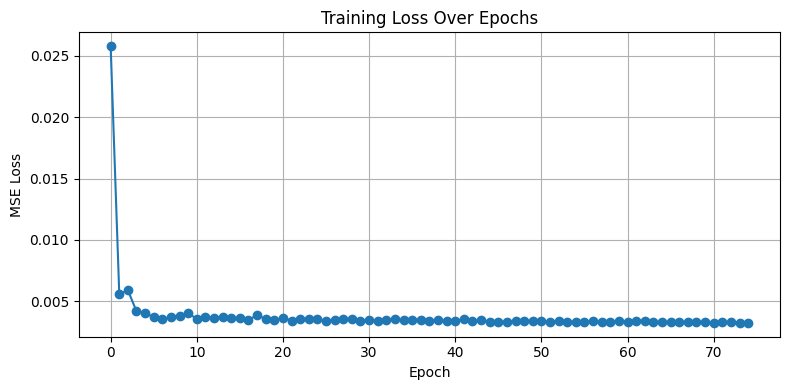

In [18]:
# Predict on full training set (in order)
net.eval()
X_full = torch.stack([temperature_scaled[i:i+seqlength] for i in range(len(temperature_scaled) - seqlength)])
with torch.no_grad():
    y_pred = net(X_full).numpy()

# Inverse transform
predictions = scaler.inverse_transform(y_pred)
actual = scaler.inverse_transform(temperature_scaled[seqlength:].numpy())

# Plot predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(actual, label='Actual Temp')
plt.plot(predictions, label='Predicted Temp')
plt.title("London Daily Temperature Prediction using LSTM – Training Data (2015–2024)")
plt.xlabel("Days Count")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Maximum Absolute Error: 8.63 °C
Mean Absolute Error (MAE): 1.38 °C
Root Mean Squared Error (RMSE): 1.77 °C


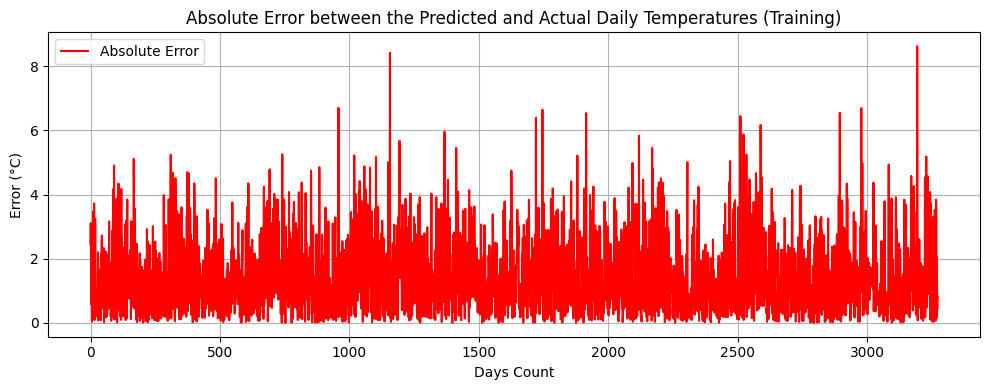

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Calculate absolute errors ---
absolute_errors = np.abs(actual - predictions)

# --- Maximum absolute error ---
max_error = np.max(absolute_errors)
print(f"Maximum Absolute Error: {max_error:.2f} °C")

# --- Optional: Show other metrics ---
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mean_squared_error(actual, predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")

# --- Plot error distribution ---
plt.figure(figsize=(10, 4))
plt.plot(absolute_errors, label="Absolute Error", color='red')
plt.title("Absolute Error between the Predicted and Actual Daily Temperatures (Training)")
plt.xlabel("Days Count")
plt.ylabel("Error (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


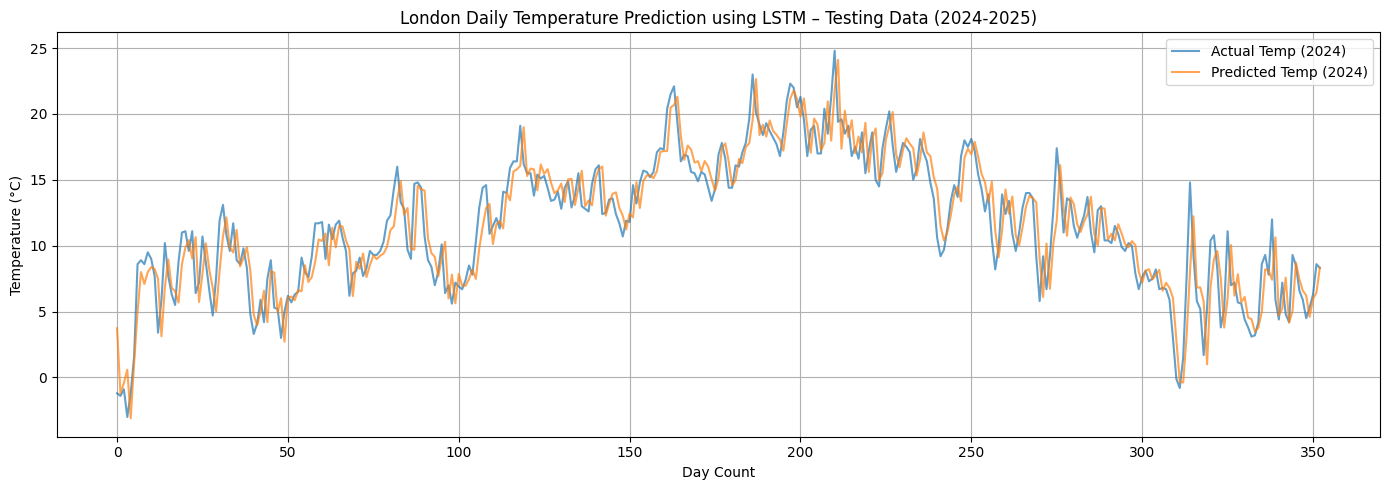

In [19]:
# --- Load 2024 Test Data ---
test_start = datetime(2024, 1, 1)
test_end = datetime(2025, 1, 1)
test_data = Daily(london, test_start, test_end).fetch()
test_temperature = test_data['tavg'].dropna().values.reshape(-1, 1)

# --- Normalize using the same scaler ---
test_temperature_norm = scaler.transform(test_temperature)
test_temperature_norm = torch.tensor(test_temperature_norm, dtype=torch.float32)

# --- Prepare Test Sequences ---
X_test = []
Y_test = []

for i in range(len(test_temperature_norm) - seqlength):
    X_test.append(test_temperature_norm[i:i+seqlength])
    Y_test.append(test_temperature_norm[i+seqlength])

X_test = torch.stack(X_test)
Y_test = torch.stack(Y_test)

# --- Evaluate on Test Set ---
net.eval()
test_predictions = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        x = X_test[i].unsqueeze(0)  # [1, seq_len, input_size]
        y_pred = net(x)             # [1, 1] or [1]
        test_predictions.append(y_pred.squeeze().item())

# --- Inverse transform predictions and ground truth ---
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
Y_test_inv = scaler.inverse_transform(Y_test.numpy())

# --- Plot predictions vs actual on test data ---
plt.figure(figsize=(14, 5))
plt.plot(Y_test_inv, label='Actual Temp (2024)', alpha=0.7)
plt.plot(test_predictions_inv, label='Predicted Temp (2024)', alpha=0.7)
plt.title("London Daily Temperature Prediction using LSTM – Testing Data (2024-2025)")
plt.xlabel("Day Count")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Maximum Absolute Error: 6.76 °C
Mean Absolute Error (MAE): 1.55 °C
Root Mean Squared Error (RMSE): 1.96 °C


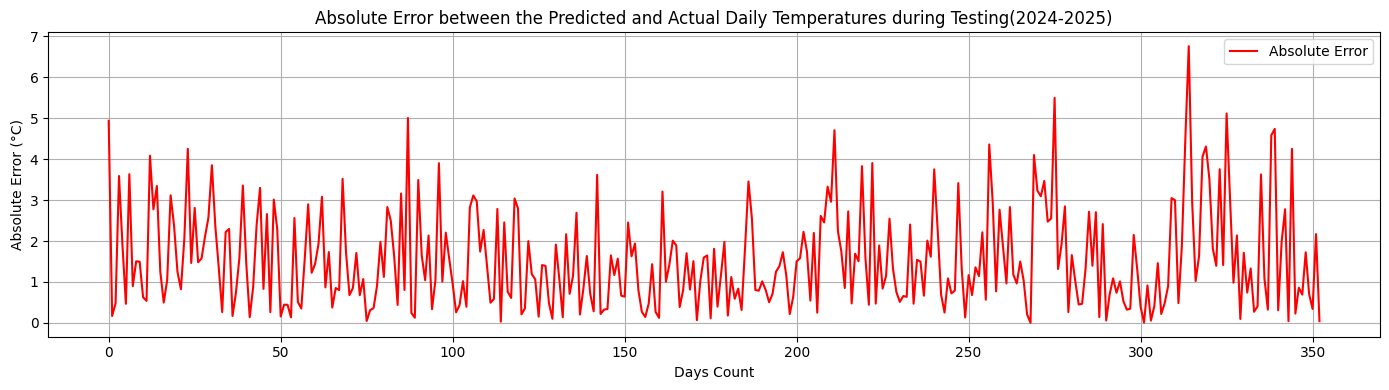

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Compute Errors ---
absolute_errors = np.abs(test_predictions_inv - Y_test_inv)
max_error = np.max(absolute_errors)
mae = mean_absolute_error(Y_test_inv, test_predictions_inv)
mse = mean_squared_error(Y_test_inv, test_predictions_inv)
rmse = np.sqrt(mse)

# --- Print Errors ---
print(f"Maximum Absolute Error: {max_error:.2f} °C")
print(f"Mean Absolute Error (MAE): {mae:.2f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")

# --- Plot Absolute Errors ---
plt.figure(figsize=(14, 4))
plt.plot(absolute_errors, label='Absolute Error', color='red')
plt.title("Absolute Error between the Predicted and Actual Daily Temperatures during Testing(2024-2025)")
plt.xlabel("Days Count")
plt.ylabel("Absolute Error (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
